In [30]:
import pandas as pd
import numpy as np
import sqlite3
from sklearn.preprocessing import MinMaxScaler
import pickle
import os

# Đảm bảo thư mục utils tồn tại
if not os.path.exists('utils'):
    os.makedirs('utils')

# Hàm giảm thiểu sử dụng bộ nhớ
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print(f'Mem. usage decreased to {end_mem:.2f} Mb ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)')
    return df

# Bước 1: Tải dữ liệu
def load_data():
    sales = pd.read_csv('C:/Users/Ho Hau/Downloads/M5/data/raw/sales_train_validation.csv')
    prices = pd.read_csv('C:/Users/Ho Hau/Downloads/M5/data/raw/sell_prices.csv')
    calendar = pd.read_csv('C:/Users/Ho Hau/Downloads/M5/data/raw/calendar.csv')
    
    sales = reduce_mem_usage(sales)
    prices = reduce_mem_usage(prices)
    calendar = reduce_mem_usage(calendar)
    
    return sales, prices, calendar

# Bước 2: Lọc dữ liệu cho California và 3 năm gần nhất
def filter_data(sales, calendar):
    sales_ca = sales[sales['state_id'] == 'CA']
    start_date = '2013-01-01'
    end_date = '2016-05-22'
    calendar['date'] = pd.to_datetime(calendar['date'])
    calendar_filtered = calendar[(calendar['date'] >= start_date) & (calendar['date'] <= end_date)]
    
    day_columns = [col for col in sales.columns if col.startswith('d_')]
    day_to_date = calendar.set_index('d')['date'].to_dict()
    selected_days = [d for d in day_columns if day_to_date.get(d, pd.Timestamp('1900-01-01')) >= pd.Timestamp(start_date)]
    
    sales_columns = ['item_id', 'store_id', 'cat_id', 'state_id'] + selected_days
    sales_ca = sales_ca[sales_columns]
    
    print("Data filtered successfully!")
    print(f"sales_ca shape: {sales_ca.shape}")
    return sales_ca, calendar_filtered, selected_days

# Bước 3: Chọn top 100 sản phẩm
def select_top_products(sales_ca, selected_days):
    sales_ca = sales_ca.copy()
    sales_sums = sales_ca[selected_days].sum(axis=1)
    sales_ca['total_sales'] = sales_sums
    top_products = sales_ca.nlargest(100, 'total_sales')['item_id'].values
    sales_top = sales_ca[sales_ca['item_id'].isin(top_products)].drop(columns=['total_sales'])
    
    print("Top products selected successfully!")
    print(f"sales_top shape: {sales_top.shape}")
    return sales_top, top_products

# Bước 4: Kỹ thuật hóa đặc trưng
def engineer_features(sales_top, prices, calendar_filtered, selected_days):
    id_columns = ['item_id', 'store_id', 'cat_id', 'state_id']
    sales_melted = pd.melt(
        sales_top,
        id_vars=id_columns,
        value_vars=selected_days,
        var_name='d',
        value_name='sales'
    )
    sales_melted = sales_melted.merge(
        calendar_filtered[['d', 'date', 'wm_yr_wk', 'weekday', 'snap_CA', 'event_name_1', 'event_name_2']],
        on='d',
        how='left'
    )
    sales_melted = sales_melted.merge(
        prices[prices['store_id'].str.contains('CA')][['store_id', 'item_id', 'wm_yr_wk', 'sell_price']],
        on=['store_id', 'item_id', 'wm_yr_wk'],
        how='left'
    )
    sales_melted['sell_price'] = sales_melted.groupby('item_id')['sell_price'].transform(lambda x: x.fillna(x.mean()))
    sales_melted = sales_melted.dropna(subset=['sell_price'])
    
    sales_melted['day_of_week'] = sales_melted['weekday'].map({
        'Monday': 0, 'Tuesday': 1, 'Wednesday': 2, 'Thursday': 3,
        'Friday': 4, 'Saturday': 5, 'Sunday': 6
    })
    sales_melted['is_holiday'] = sales_melted[['event_name_1', 'event_name_2']].notnull().any(axis=1).astype(int)
    sales_melted['month'] = sales_melted['date'].dt.month
    sales_melted['day_of_month'] = sales_melted['date'].dt.day
    
    sales_melted = sales_melted.sort_values(['item_id', 'store_id', 'date'])
    for lag in [7, 14, 28]:
        sales_melted[f'sales_lag_{lag}'] = sales_melted.groupby(['item_id', 'store_id'])['sales'].shift(lag)
    for window in [7, 14]:
        sales_melted[f'sales_roll_mean_{window}'] = sales_melted.groupby(['item_id', 'store_id'])['sales'].shift(1).rolling(window=window).mean()
    sales_melted = sales_melted.fillna(0)
    
    features = ['sales', 'sell_price', 'day_of_week', 'snap_CA', 'is_holiday', 'month', 'day_of_month',
                'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14']
    sales_melted = sales_melted[['item_id', 'store_id', 'date'] + features]
    
    # In thống kê sales gốc
    print("Thống kê sales gốc:")
    print(sales_melted['sales'].describe())
    
    # Chuẩn hóa dữ liệu
    scaler = MinMaxScaler()
    sales_melted[features] = scaler.fit_transform(sales_melted[features])
    
    # Lưu scaler
    with open('utils/scaler1.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    
    print("Feature engineering completed!")
    print(f"sales_melted shape: {sales_melted.shape}")
    return sales_melted, features, scaler

# Bước 5: Lưu vào SQLite
def save_to_sqlite(sales_melted, features):
    conn = sqlite3.connect('historical_data1.db')
    sales_melted.to_sql('historical_data1', conn, if_exists='replace', index=False)
    conn.close()
    print("Data saved to SQLite successfully!")

# Hàm chính cho tiền xử lý
def main_preprocess():
    sales, prices, calendar = load_data()
    sales_ca, calendar_filtered, selected_days = filter_data(sales, calendar)
    sales_top, top_products = select_top_products(sales_ca, selected_days)
    sales_melted, features, scaler = engineer_features(sales_top, prices, calendar_filtered, selected_days)
    save_to_sqlite(sales_melted, features)

if __name__ == "__main__":
    main_preprocess()

Mem. usage decreased to 95.00 Mb (78.7% reduction)
Mem. usage decreased to 130.48 Mb (37.5% reduction)
Mem. usage decreased to 0.12 Mb (41.9% reduction)
Data filtered successfully!
sales_ca shape: (12196, 1214)
Top products selected successfully!
sales_top shape: (252, 1214)
Thống kê sales gốc:
count    304920.000000
mean         13.322403
std          18.549349
min           0.000000
25%           2.000000
50%           8.000000
75%          18.000000
max         763.000000
Name: sales, dtype: float64
Feature engineering completed!
sales_melted shape: (304920, 15)
Data saved to SQLite successfully!


In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import os
from torchinfo import summary
import time

# Thiết lập môi trường
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Đang sử dụng thiết bị: {device}")

# Định nghĩa các case tham số
cases = {
    1: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3},
    2: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3},
    3: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3},
    4: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 3, 'dropout': 0.2},
    5: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.1},
}

# Bước 1: Tải dữ liệu từ SQLite
def load_data_from_sqlite():
    conn = sqlite3.connect('historical_data1.db')
    query = "SELECT * FROM historical_data1 ORDER BY item_id, store_id, date"
    data = pd.read_sql_query(query, conn)
    conn.close()
    data['date'] = pd.to_datetime(data['date'])
    print("Data loaded from SQLite successfully!")
    print(f"Data shape: {data.shape}")
    print("Checking for NaN in features...")
    print(data.isna().sum())
    return data

# Dataset và DataLoader
class SalesDataset(Dataset):
    def __init__(self, X, y, info=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.info = info
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.info is not None:
            return self.X[idx], self.y[idx], self.info[idx]
        return self.X[idx], self.y[idx]

def prepare_lstm_data(data, features, sequence_length, batch_size):
    X, y, info = [], [], []
    unique_items = data[['item_id', 'store_id']].drop_duplicates().values
    
    valid_pairs = 0
    for item_id, store_id in unique_items:
        item_data = data[(data['item_id'] == item_id) & (data['store_id'] == store_id)].sort_values('date')
        if len(item_data) < sequence_length + 1:
            continue
        valid_pairs += 1
        item_features = item_data[features].values
        item_dates = item_data['date'].astype(str).values
        num_samples = len(item_data) - sequence_length
        for i in range(num_samples):
            X.append(item_features[i:i + sequence_length])
            y.append(item_features[i + sequence_length, 0])
            info.append((item_id, store_id, item_dates[i + sequence_length]))
    
    X = np.array(X)
    y = np.array(y)
    info = np.array(info, dtype=object)
    
    print(f"Total samples created: X={len(X)}, y={len(y)}, info={len(info)}")
    if not (len(X) == len(y) == len(info)):
        raise ValueError(f"Mismatch in total samples: X={len(X)}, y={len(y)}, info={len(info)}")
    
    train_size = int(0.7 * len(X))
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    info_val = info[train_size:].tolist()
    
    print(f"Train samples: X_train={len(X_train)}, y_train={len(y_train)}")
    print(f"Validation samples: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Mismatch in validation data: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    train_dataset = SalesDataset(X_train, y_train)
    val_dataset = SalesDataset(X_val, y_val, info_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print("LSTM data prepared successfully!")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"Length of info_val: {len(info_val)}")
    return train_loader, val_loader, X_val, y_val, info_val

# Mô hình LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=3, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Callback cho huấn luyện
class TrainingCallback:
    def __init__(self, patience, case_name):
        self.patience = patience
        self.best_val_loss = float('inf')
        self.counter = 0
        self.model_path = f"{case_name}_best.pth"
        self.metrics = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_mae': []}
    
    def on_epoch_end(self, epoch, model, train_loss, val_loss, val_rmse, val_mae, epoch_time):
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f}, Val RMSE={val_rmse:.6f}, Val MAE={val_mae:.6f}, Time={epoch_time:.2f}s")
        self.metrics['train_loss'].append(train_loss)
        self.metrics['val_loss'].append(val_loss)
        self.metrics['val_rmse'].append(val_rmse)
        self.metrics['val_mae'].append(val_mae)
        
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.model_path)
            print(f"Đã lưu mô hình tốt nhất tại {self.model_path}")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Dừng sớm được kích hoạt.")
                return True
        return False

# Huấn luyện mô hình
def train_model(model, train_loader, val_loader, num_epochs, patience, scaler, case_name):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, min_lr=1e-5)
    callback = TrainingCallback(patience, case_name)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)
 
        model.eval()
        val_loss = 0
        y_pred_list = []
        y_true_list = []
        with torch.no_grad():
            for batch in val_loader:
                X_batch, y_batch, _ = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item() * X_batch.size(0)
                y_pred_list.append(outputs.squeeze().cpu().numpy())
                y_true_list.append(y_batch.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        y_pred = np.concatenate(y_pred_list)
        y_true = np.concatenate(y_true_list)
        val_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        val_mae = mean_absolute_error(y_true, y_pred)
        epoch_time = time.time() - start_time
        scheduler.step(val_loss)
        stop = callback.on_epoch_end(epoch, model, train_loss, val_loss, val_rmse, val_mae, epoch_time)
        torch.cuda.empty_cache()
        if stop:
            break
    return model, callback.metrics

# Đánh giá mô hình
def evaluate_model(model, X_val, y_val, info_val, scaler, batch_size):
    model.eval()
    dataset = SalesDataset(X_val, y_val, info_val)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    y_pred_list = []
    y_true_list = []
    info_list = []
    current_idx = 0
    
    with torch.no_grad():
        for X_batch, y_batch, _ in data_loader:
            batch_size_actual = X_batch.shape[0]
            
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            y_pred_batch = outputs.squeeze().cpu().numpy()
            y_true_batch = y_batch.numpy()
            
            batch_info = info_val[current_idx:current_idx + batch_size_actual]
            if len(batch_info) != batch_size_actual:
                raise ValueError(f"Info size mismatch in batch at index {current_idx}: expected {batch_size_actual}, got {len(batch_info)}")
            
            y_pred_list.append(y_pred_batch)
            y_true_list.append(y_true_batch)
            info_list.extend(batch_info)
            
            current_idx += batch_size_actual
    
    y_pred = np.concatenate(y_pred_list)
    y_true = np.concatenate(y_true_list)
    
    print("Length of info_list:", len(info_list))
    print("Length of y_true:", len(y_true))
    print("Length of y_pred:", len(y_pred))
    
    if not (len(info_list) == len(y_true) == len(y_pred)):
        raise ValueError(f"Mismatch in lengths: info_list={len(info_list)}, y_true={len(y_true)}, y_pred={len(y_pred)}")
    
    rmse_scaled = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_scaled = mean_absolute_error(y_true, y_pred)
    
    y_true_orig = scaler.inverse_transform(np.array([y_true] + [np.zeros(len(y_true))] * (len(scaler.feature_names_in_) - 1)).T)[:, 0]
    y_pred_orig = scaler.inverse_transform(np.array([y_pred] + [np.zeros(len(y_pred))] * (len(scaler.feature_names_in_) - 1)).T)[:, 0]
    
    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    
    val_df = pd.DataFrame({
        'item_id': [info[0] for info in info_list],
        'store_id': [info[1] for info in info_list],
        'date': [info[2] for info in info_list],
        'actual': y_true_orig,
        'predicted': y_pred_orig
    })
    wrmsse = calculate_wrmsse(val_df)
    
    print("\nChỉ số trên dữ liệu chuẩn hóa:")
    print(f"RMSE (chuẩn hóa): {rmse_scaled:.6f}")
    print(f"MAE (chuẩn hóa): {mae_scaled:.6f}")
    print("\nChỉ số trên dữ liệu gốc:")
    print(f"RMSE (gốc): {rmse_orig:.4f}")
    print(f"MAE (gốc): {mae_orig:.4f}")
    print(f"WRMSSE: {wrmsse:.4f}")
    
    return y_pred_orig, rmse_orig, mae_orig, wrmsse

# Tính WRMSSE
def calculate_wrmsse(val_df):
    groups = val_df.groupby(['item_id', 'store_id'])
    wrmsse = 0
    total_weight = 0
    for _, group in groups:
        actual = group['actual'].values
        predicted = group['predicted'].values
        if len(actual) > 1:
            naive_forecast_error = np.mean((actual[1:] - actual[:-1])**2)
            mse = np.mean((actual - predicted)**2)
            rmsse = np.sqrt(mse / naive_forecast_error) if naive_forecast_error > 0 else 0
        else:
            rmsse = 0
        weight = np.mean(actual)
        wrmsse += weight * rmsse
        total_weight += weight
    return wrmsse / total_weight if total_weight > 0 else 0

# Hiển thị kiến trúc mô hình
def print_model_summary(model, input_size):
    print("Model Summary:")
    summary(model, input_size=(1, *input_size), col_names=["input_size", "output_size", "num_params"], verbose=1)

Đang sử dụng thiết bị: cuda


In [16]:
# Hàm chính cho huấn luyện và đánh giá
def main_train():
    torch.cuda.empty_cache()
    
    data = load_data_from_sqlite()
    
    with open('utils/scaler1.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    features = ['sales', 'sell_price', 'day_of_week', 'snap_CA', 'is_holiday', 'month', 'day_of_month',
                'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14']
    
    print("\nCác case tham số có sẵn:")
    for case_num, params in cases.items():
        print(f"Case {case_num}: {params}")
    print("Nhập '0' để tự định nghĩa case mới.")
    
    case_choice = int(input("Nhập số case (0-5): "))
    
    if case_choice == 0:
        params = {
            'sequence_length': int(input("Nhập sequence_length: ")),
            'batch_size': int(input("Nhập batch_size: ")),
            'num_epochs': int(input("Nhập num_epochs: ")),
            'patience': int(input("Nhập patience: ")),
            'dropout': float(input("Nhập dropout (0.0-1.0): ")),
            'hidden_size': int(input("Nhập hidden_size: "))  # Thêm hidden_size
        }
        case_name = f"lstm_model_custom_{params['sequence_length']}_{params['batch_size']}_{params['hidden_size']}"
    else:
        params = cases.get(case_choice, cases[1])
        params['hidden_size'] = 128  # Thêm hidden_size mặc định cho các case có sẵn
        case_name = f"lstm_model_{case_choice}"
    
    print(f"Đang chạy với tham số: {params}")
    print(f"Tên mô hình: {case_name}")
    
    train_loader, val_loader, X_val, y_val, info_val = prepare_lstm_data(
        data, features, params['sequence_length'], params['batch_size']
    )
    
    print("Kiểm tra dữ liệu trước khi huấn luyện...")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Dữ liệu validation không đồng bộ: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    model = LSTMModel(
        input_size=len(features),
        hidden_size=params['hidden_size'],
        dropout=params['dropout']
    ).to(device)
    print_model_summary(model, (params['sequence_length'], len(features)))
    
    model, metrics = train_model(model, train_loader, val_loader, params['num_epochs'], params['patience'], scaler, case_name)
    
    y_pred, rmse, mae, wrmsse = evaluate_model(model, X_val, y_val, info_val, scaler, params['batch_size'])
    
    print("\nHuấn luyện và đánh giá hoàn tất!")
    
    final_model_path = f"{case_name}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Mô hình cuối cùng đã được lưu tại {final_model_path}")
    
    # Trả về dictionary chứa tất cả các biến cần thiết
    return {
        'model': model,
        'y_pred': y_pred,
        'y_val': y_val,
        'info_val': info_val,
        'scaler': scaler,
        'rmse': rmse,
        'mae': mae,
        'wrmsse': wrmsse,
        'case_name': case_name
    }

if __name__ == "__main__":
    results = main_train()
    # Gán các biến để sử dụng trong cell vẽ biểu đồ
    model = results['model']
    y_pred = results['y_pred']
    y_val = results['y_val']
    info_val = results['info_val']
    scaler = results['scaler']
    rmse = results['rmse']
    mae = results['mae']
    wrmsse = results['wrmsse']
    case_name = results['case_name']

Data loaded from SQLite successfully!
Data shape: (304920, 15)
Checking for NaN in features...
item_id               0
store_id              0
date                  0
sales                 0
sell_price            0
day_of_week           0
snap_CA               0
is_holiday            0
month                 0
day_of_month          0
sales_lag_7           0
sales_lag_14          0
sales_lag_28          0
sales_roll_mean_7     0
sales_roll_mean_14    0
dtype: int64

Các case tham số có sẵn:
Case 1: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 2: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 3: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3}
Case 4: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 3, 'dropout': 0.2}
Case 5: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.1}
Nhập '0' để

Các cặp item_id, store_id trong tập validation: {('HOUSEHOLD_1_465', 'CA_2'), ('HOUSEHOLD_1_334', 'CA_1'), ('HOUSEHOLD_1_339', 'CA_3'), ('HOUSEHOLD_1_447', 'CA_4'), ('HOUSEHOLD_1_339', 'CA_2'), ('HOUSEHOLD_1_418', 'CA_1'), ('HOUSEHOLD_1_409', 'CA_3'), ('FOODS_3_808', 'CA_3'), ('FOODS_3_764', 'CA_3'), ('HOUSEHOLD_1_303', 'CA_3'), ('HOUSEHOLD_1_351', 'CA_4'), ('HOUSEHOLD_1_409', 'CA_2'), ('FOODS_3_764', 'CA_2'), ('HOUSEHOLD_1_447', 'CA_1'), ('FOODS_3_808', 'CA_2'), ('HOUSEHOLD_1_019', 'CA_3'), ('HOUSEHOLD_1_521', 'CA_4'), ('HOUSEHOLD_1_521', 'CA_3'), ('FOODS_3_804', 'CA_3'), ('HOUSEHOLD_1_118', 'CA_4'), ('HOUSEHOLD_1_277', 'CA_4'), ('FOODS_3_811', 'CA_4'), ('HOUSEHOLD_1_303', 'CA_2'), ('HOBBIES_1_234', 'CA_3'), ('HOUSEHOLD_1_019', 'CA_2'), ('HOUSEHOLD_1_110', 'CA_4'), ('HOUSEHOLD_1_351', 'CA_1'), ('HOUSEHOLD_1_459', 'CA_4'), ('HOUSEHOLD_1_521', 'CA_2'), ('FOODS_3_804', 'CA_2'), ('HOUSEHOLD_1_118', 'CA_1'), ('HOBBIES_1_234', 'CA_2'), ('HOUSEHOLD_1_465', 'CA_4'), ('HOUSEHOLD_1_277', 'CA_1'

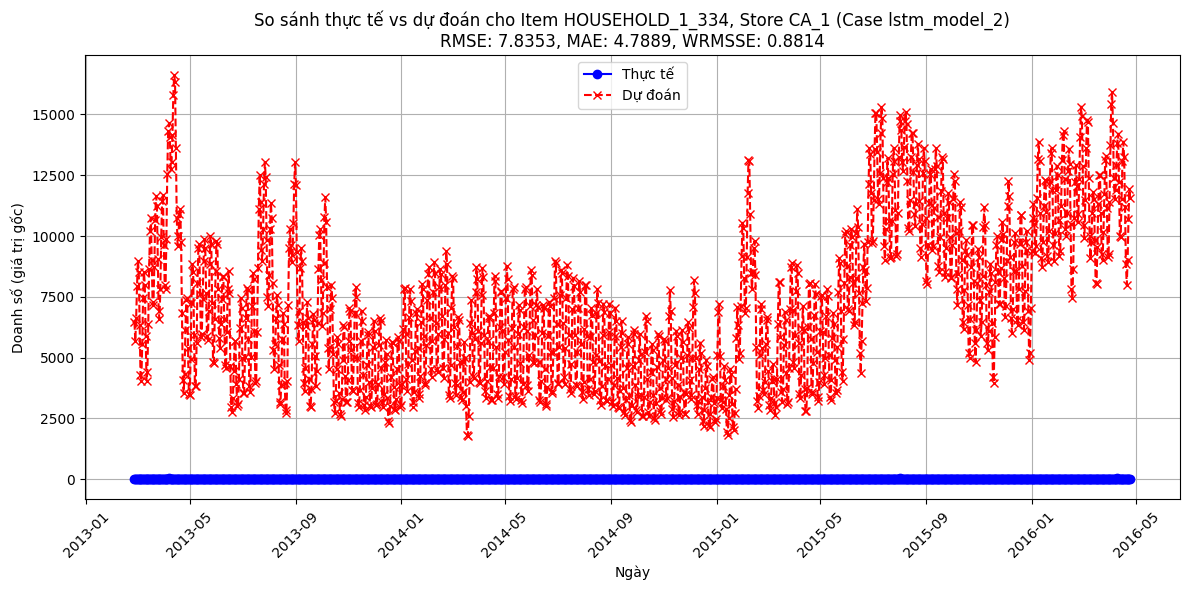

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Hàm để vẽ biểu đồ so sánh dữ liệu thực tế và dự đoán
def plot_actual_vs_predicted(y_true, y_pred, info_val, scaler, rmse, mae, wrmsse, case_name, num_samples=100, item_id=None, store_id=None):
    """
    Vẽ biểu đồ so sánh dữ liệu thực tế và dự đoán trên tập validation.
    
    Parameters:
    - y_true: Giá trị thực tế (chuẩn hóa) từ tập validation.
    - y_pred: Giá trị dự đoán (chuẩn hóa) từ mô hình.
    - info_val: Thông tin về item_id, store_id, và date cho tập validation.
    - scaler: Scaler để chuyển đổi ngược về giá trị gốc.
    - rmse: RMSE trên giá trị gốc.
    - mae: MAE trên giá trị gốc.
    - wrmsse: WRMSSE trên giá trị gốc.
    - case_name: Tên case để hiển thị trong tiêu đề và lưu file.
    - num_samples: Số mẫu tối đa để vẽ (mặc định: 100).
    - item_id: Nếu được cung cấp, chỉ vẽ cho item_id cụ thể.
    - store_id: Nếu được cung cấp, chỉ vẽ cho store_id cụ thể.
    """
    # Chuyển đổi y_true và y_pred về giá trị gốc
    y_true_orig = scaler.inverse_transform(np.array([y_true] + [np.zeros(len(y_true))] * (len(scaler.feature_names_in_) - 1)).T)[:, 0]
    y_pred_orig = scaler.inverse_transform(np.array([y_pred] + [np.zeros(len(y_pred))] * (len(scaler.feature_names_in_) - 1)).T)[:, 0]
    
    # Tạo DataFrame từ info_val để dễ lọc
    val_df = pd.DataFrame({
        'item_id': [info[0] for info in info_val],
        'store_id': [info[1] for info in info_val],
        'date': [info[2] for info in info_val],
        'actual': y_true_orig,
        'predicted': y_pred_orig
    })
    
    # Lọc theo item_id và store_id nếu được cung cấp
    if item_id is not None and store_id is not None:
        val_df = val_df[(val_df['item_id'] == item_id) & (val_df['store_id'] == store_id)]
        if val_df.empty:
            print(f"Không có dữ liệu cho item_id={item_id} và store_id={store_id} trong tập validation.")
            return
        title = f'So sánh thực tế vs dự đoán cho Item {item_id}, Store {store_id} (Case {case_name})'
    else:
        # Lấy một số mẫu đầu tiên nếu không lọc
        val_df = val_df.iloc[:min(num_samples, len(val_df))]
        title = f'So sánh thực tế vs dự đoán trên {len(val_df)} mẫu đầu tiên (Case {case_name})'
    
    # Sắp xếp theo date để vẽ theo thứ tự thời gian
    val_df['date'] = pd.to_datetime(val_df['date'])
    val_df = val_df.sort_values('date')
    
    # Vẽ biểu đồ
    plt.figure(figsize=(12, 6))
    plt.plot(val_df['date'], val_df['actual'], label='Thực tế', color='blue', marker='o', linestyle='-')
    plt.plot(val_df['date'], val_df['predicted'], label='Dự đoán', color='red', marker='x', linestyle='--')
    
    # Thêm tiêu đề và nhãn
    plt.title(f'{title}\nRMSE: {rmse:.4f}, MAE: {mae:.4f}, WRMSSE: {wrmsse:.4f}')
    plt.xlabel('Ngày')
    plt.ylabel('Doanh số (giá trị gốc)')
    plt.legend()
    plt.grid(True)
    
    # Xoay nhãn ngày để dễ đọc
    plt.xticks(rotation=45)
    
    # Điều chỉnh layout để tránh cắt nhãn
    plt.tight_layout()
    
    # Lưu biểu đồ
    plt.savefig(f'actual_vs_predicted_{case_name}.png', dpi=300, bbox_inches='tight')
    
    # Hiển thị biểu đồ
    plt.show()

# Kiểm tra các item_id và store_id trong tập validation
unique_items = set((info[0], info[1]) for info in info_val)
print("Các cặp item_id, store_id trong tập validation:", unique_items)

# Vẽ biểu đồ cho 100 mẫu đầu tiên
#plot_actual_vs_predicted(y_val, y_pred, info_val, scaler, rmse, mae, wrmsse, case_name, num_samples=100)

# Vẽ biểu đồ cho một sản phẩm và cửa hàng cụ thể (thay bằng item_id và store_id thực tế)
# Ví dụ:
plot_actual_vs_predicted(y_val, y_pred, info_val, scaler, rmse, mae, wrmsse, case_name, item_id='HOUSEHOLD_1_334', store_id='CA_1')

CASE 2

In [28]:
# Hàm chính cho huấn luyện và đánh giá
def main_train():
    torch.cuda.empty_cache()
    
    data = load_data_from_sqlite()
    
    with open('utils/scaler1.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    features = ['sales', 'sell_price', 'day_of_week', 'snap_CA', 'is_holiday', 'month', 'day_of_month',
                'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14']
    
    print("\nCác case tham số có sẵn:")
    for case_num, params in cases.items():
        print(f"Case {case_num}: {params}")
    print("Nhập '0' để tự định nghĩa case mới.")
    
    case_choice = int(input("Nhập số case (0-5): "))
    
    if case_choice == 0:
        params = {
            'sequence_length': int(input("Nhập sequence_length: ")),
            'batch_size': int(input("Nhập batch_size: ")),
            'num_epochs': int(input("Nhập num_epochs: ")),
            'patience': int(input("Nhập patience: ")),
            'dropout': float(input("Nhập dropout (0.0-1.0): "))
        }
        case_name = "lstm_model_custom"
    else:
        params = cases.get(case_choice, cases[1])
        case_name = f"lstm_model_{case_choice}"
    
    print(f"Đang chạy với tham số: {params}")
    print(f"Tên mô hình: {case_name}")
    
    train_loader, val_loader, X_val, y_val, info_val = prepare_lstm_data(
        data, features, params['sequence_length'], params['batch_size']
    )
    
    print("Kiểm tra dữ liệu trước khi huấn luyện...")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Dữ liệu validation không đồng bộ: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    model = LSTMModel(input_size=len(features), dropout=params['dropout']).to(device)
    print_model_summary(model, (params['sequence_length'], len(features)))
    
    model, metrics = train_model(model, train_loader, val_loader, params['num_epochs'], params['patience'], scaler, case_name)
    
    y_pred, rmse, mae, wrmsse = evaluate_model(model, X_val, y_val, info_val, scaler, params['batch_size'])
    
    print("\nHuấn luyện và đánh giá hoàn tất!")
    
    final_model_path = f"{case_name}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Mô hình cuối cùng đã được lưu tại {final_model_path}")
    
    return model, y_pred, rmse, mae, wrmsse

if __name__ == "__main__":
    model, y_pred, rmse, mae, wrmsse = main_train()

Data loaded from SQLite successfully!
Data shape: (304920, 15)
Checking for NaN in features...
item_id               0
store_id              0
date                  0
sales                 0
sell_price            0
day_of_week           0
snap_CA               0
is_holiday            0
month                 0
day_of_month          0
sales_lag_7           0
sales_lag_14          0
sales_lag_28          0
sales_roll_mean_7     0
sales_roll_mean_14    0
dtype: int64

Các case tham số có sẵn:
Case 1: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 2: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 3: {'sequence_length': 28, 'batch_size': 64, 'num_epochs': 20, 'patience': 7, 'dropout': 0.4}
Case 4: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 3, 'dropout': 0.2}
Case 5: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 25, 'patience': 5, 'dropout': 0.1}
Nhập '0' để

Case 3 / ÁP DỤNG 

In [42]:
# Hàm chính cho huấn luyện và đánh giá
def main_train():
    torch.cuda.empty_cache()
    
    data = load_data_from_sqlite()
    
    with open('utils/scaler1.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    features = ['sales', 'sell_price', 'day_of_week', 'snap_CA', 'is_holiday', 'month', 'day_of_month',
                'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14']
    
    print("\nCác case tham số có sẵn:")
    for case_num, params in cases.items():
        print(f"Case {case_num}: {params}")
    print("Nhập '0' để tự định nghĩa case mới.")
    
    case_choice = int(input("Nhập số case (0-5): "))
    
    if case_choice == 0:
        params = {
            'sequence_length': int(input("Nhập sequence_length: ")),
            'batch_size': int(input("Nhập batch_size: ")),
            'num_epochs': int(input("Nhập num_epochs: ")),
            'patience': int(input("Nhập patience: ")),
            'dropout': float(input("Nhập dropout (0.0-1.0): "))
        }
        case_name = "lstm_model_custom"
    else:
        params = cases.get(case_choice, cases[1])
        case_name = f"lstm_model_{case_choice}"
    
    print(f"Đang chạy với tham số: {params}")
    print(f"Tên mô hình: {case_name}")
    
    train_loader, val_loader, X_val, y_val, info_val = prepare_lstm_data(
        data, features, params['sequence_length'], params['batch_size']
    )
    
    print("Kiểm tra dữ liệu trước khi huấn luyện...")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Dữ liệu validation không đồng bộ: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    model = LSTMModel(input_size=len(features), dropout=params['dropout']).to(device)
    print_model_summary(model, (params['sequence_length'], len(features)))
    
    model, metrics = train_model(model, train_loader, val_loader, params['num_epochs'], params['patience'], scaler, case_name)
    
    y_pred, rmse, mae, wrmsse = evaluate_model(model, X_val, y_val, info_val, scaler, params['batch_size'])
    
    print("\nHuấn luyện và đánh giá hoàn tất!")
    
    final_model_path = f"{case_name}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Mô hình cuối cùng đã được lưu tại {final_model_path}")
    
    return model, y_pred, rmse, mae, wrmsse

if __name__ == "__main__":
    model, y_pred, rmse, mae, wrmsse = main_train()

Data loaded from SQLite successfully!
Data shape: (304920, 15)
Checking for NaN in features...
item_id               0
store_id              0
date                  0
sales                 0
sell_price            0
day_of_week           0
snap_CA               0
is_holiday            0
month                 0
day_of_month          0
sales_lag_7           0
sales_lag_14          0
sales_lag_28          0
sales_roll_mean_7     0
sales_roll_mean_14    0
dtype: int64

Các case tham số có sẵn:
Case 1: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 2: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 3: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3}
Case 4: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 3, 'dropout': 0.2}
Case 5: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 25, 'patience': 5, 'dropout': 0.1}
Nhập '0' để

Case 4 

In [43]:
# Hàm chính cho huấn luyện và đánh giá
def main_train():
    torch.cuda.empty_cache()
    
    data = load_data_from_sqlite()
    
    with open('utils/scaler1.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    features = ['sales', 'sell_price', 'day_of_week', 'snap_CA', 'is_holiday', 'month', 'day_of_month',
                'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14']
    
    print("\nCác case tham số có sẵn:")
    for case_num, params in cases.items():
        print(f"Case {case_num}: {params}")
    print("Nhập '0' để tự định nghĩa case mới.")
    
    case_choice = int(input("Nhập số case (0-5): "))
    
    if case_choice == 0:
        params = {
            'sequence_length': int(input("Nhập sequence_length: ")),
            'batch_size': int(input("Nhập batch_size: ")),
            'num_epochs': int(input("Nhập num_epochs: ")),
            'patience': int(input("Nhập patience: ")),
            'dropout': float(input("Nhập dropout (0.0-1.0): "))
        }
        case_name = "lstm_model_custom"
    else:
        params = cases.get(case_choice, cases[1])
        case_name = f"lstm_model_{case_choice}"
    
    print(f"Đang chạy với tham số: {params}")
    print(f"Tên mô hình: {case_name}")
    
    train_loader, val_loader, X_val, y_val, info_val = prepare_lstm_data(
        data, features, params['sequence_length'], params['batch_size']
    )
    
    print("Kiểm tra dữ liệu trước khi huấn luyện...")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Dữ liệu validation không đồng bộ: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    model = LSTMModel(input_size=len(features), dropout=params['dropout']).to(device)
    print_model_summary(model, (params['sequence_length'], len(features)))
    
    model, metrics = train_model(model, train_loader, val_loader, params['num_epochs'], params['patience'], scaler, case_name)
    
    y_pred, rmse, mae, wrmsse = evaluate_model(model, X_val, y_val, info_val, scaler, params['batch_size'])
    
    print("\nHuấn luyện và đánh giá hoàn tất!")
    
    final_model_path = f"{case_name}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Mô hình cuối cùng đã được lưu tại {final_model_path}")
    
    return model, y_pred, rmse, mae, wrmsse

if __name__ == "__main__":
    model, y_pred, rmse, mae, wrmsse = main_train()

Data loaded from SQLite successfully!
Data shape: (304920, 15)
Checking for NaN in features...
item_id               0
store_id              0
date                  0
sales                 0
sell_price            0
day_of_week           0
snap_CA               0
is_holiday            0
month                 0
day_of_month          0
sales_lag_7           0
sales_lag_14          0
sales_lag_28          0
sales_roll_mean_7     0
sales_roll_mean_14    0
dtype: int64

Các case tham số có sẵn:
Case 1: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 2: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 3: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3}
Case 4: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 3, 'dropout': 0.2}
Case 5: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 25, 'patience': 5, 'dropout': 0.1}
Nhập '0' để

case 5

In [45]:
# Hàm chính cho huấn luyện và đánh giá
def main_train():
    torch.cuda.empty_cache()
    
    data = load_data_from_sqlite()
    
    with open('utils/scaler1.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    features = ['sales', 'sell_price', 'day_of_week', 'snap_CA', 'is_holiday', 'month', 'day_of_month',
                'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14']
    
    print("\nCác case tham số có sẵn:")
    for case_num, params in cases.items():
        print(f"Case {case_num}: {params}")
    print("Nhập '0' để tự định nghĩa case mới.")
    
    case_choice = int(input("Nhập số case (0-5): "))
    
    if case_choice == 0:
        params = {
            'sequence_length': int(input("Nhập sequence_length: ")),
            'batch_size': int(input("Nhập batch_size: ")),
            'num_epochs': int(input("Nhập num_epochs: ")),
            'patience': int(input("Nhập patience: ")),
            'dropout': float(input("Nhập dropout (0.0-1.0): "))
        }
        case_name = "lstm_model_custom"
    else:
        params = cases.get(case_choice, cases[1])
        case_name = f"lstm_model_{case_choice}"
    
    print(f"Đang chạy với tham số: {params}")
    print(f"Tên mô hình: {case_name}")
    
    train_loader, val_loader, X_val, y_val, info_val = prepare_lstm_data(
        data, features, params['sequence_length'], params['batch_size']
    )
    
    print("Kiểm tra dữ liệu trước khi huấn luyện...")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Dữ liệu validation không đồng bộ: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    model = LSTMModel(input_size=len(features), dropout=params['dropout']).to(device)
    print_model_summary(model, (params['sequence_length'], len(features)))
    
    model, metrics = train_model(model, train_loader, val_loader, params['num_epochs'], params['patience'], scaler, case_name)
    
    y_pred, rmse, mae, wrmsse = evaluate_model(model, X_val, y_val, info_val, scaler, params['batch_size'])
    
    print("\nHuấn luyện và đánh giá hoàn tất!")
    
    final_model_path = f"{case_name}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Mô hình cuối cùng đã được lưu tại {final_model_path}")
    
    return model, y_pred, rmse, mae, wrmsse

if __name__ == "__main__":
    model, y_pred, rmse, mae, wrmsse = main_train()

Data loaded from SQLite successfully!
Data shape: (304920, 15)
Checking for NaN in features...
item_id               0
store_id              0
date                  0
sales                 0
sell_price            0
day_of_week           0
snap_CA               0
is_holiday            0
month                 0
day_of_month          0
sales_lag_7           0
sales_lag_14          0
sales_lag_28          0
sales_roll_mean_7     0
sales_roll_mean_14    0
dtype: int64

Các case tham số có sẵn:
Case 1: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 2: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 3: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3}
Case 4: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 3, 'dropout': 0.2}
Case 5: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.1}
Nhập '0' để

Case 8


In [7]:
# Định nghĩa các case tham số
cases = {
    1: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3},
    2: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3},
    3: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3},
    4: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 3, 'dropout': 0.2},
    5: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.1},
    6: {'sequence_length': 28, 'batch_size': 64, 'num_epochs': 30, 'patience': 7, 'dropout': 0.1},
    7: {'sequence_length': 56, 'batch_size': 64, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3},
    8: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3},

    
}

In [51]:
# Hàm chính cho huấn luyện và đánh giá
def main_train():
    torch.cuda.empty_cache()
    
    data = load_data_from_sqlite()
    
    with open('utils/scaler1.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    features = ['sales', 'sell_price', 'day_of_week', 'snap_CA', 'is_holiday', 'month', 'day_of_month',
                'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14']
    
    print("\nCác case tham số có sẵn:")
    for case_num, params in cases.items():
        print(f"Case {case_num}: {params}")
    print("Nhập '0' để tự định nghĩa case mới.")
    
    case_choice = int(input("Nhập số case (0-5): "))
    
    if case_choice == 0:
        params = {
            'sequence_length': int(input("Nhập sequence_length: ")),
            'batch_size': int(input("Nhập batch_size: ")),
            'num_epochs': int(input("Nhập num_epochs: ")),
            'patience': int(input("Nhập patience: ")),
            'dropout': float(input("Nhập dropout (0.0-1.0): "))
        }
        case_name = "lstm_model_custom"
    else:
        params = cases.get(case_choice, cases[1])
        case_name = f"lstm_model_{case_choice}"
    
    print(f"Đang chạy với tham số: {params}")
    print(f"Tên mô hình: {case_name}")
    
    train_loader, val_loader, X_val, y_val, info_val = prepare_lstm_data(
        data, features, params['sequence_length'], params['batch_size']
    )
    
    print("Kiểm tra dữ liệu trước khi huấn luyện...")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Dữ liệu validation không đồng bộ: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    model = LSTMModel(input_size=len(features), dropout=params['dropout']).to(device)
    print_model_summary(model, (params['sequence_length'], len(features)))
    
    model, metrics = train_model(model, train_loader, val_loader, params['num_epochs'], params['patience'], scaler, case_name)
    
    y_pred, rmse, mae, wrmsse = evaluate_model(model, X_val, y_val, info_val, scaler, params['batch_size'])
    
    print("\nHuấn luyện và đánh giá hoàn tất!")
    
    final_model_path = f"{case_name}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Mô hình cuối cùng đã được lưu tại {final_model_path}")
    
    return model, y_pred, rmse, mae, wrmsse

if __name__ == "__main__":
    model, y_pred, rmse, mae, wrmsse = main_train()

Data loaded from SQLite successfully!
Data shape: (304920, 15)
Checking for NaN in features...
item_id               0
store_id              0
date                  0
sales                 0
sell_price            0
day_of_week           0
snap_CA               0
is_holiday            0
month                 0
day_of_month          0
sales_lag_7           0
sales_lag_14          0
sales_lag_28          0
sales_roll_mean_7     0
sales_roll_mean_14    0
dtype: int64

Các case tham số có sẵn:
Case 1: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 2: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 3: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3}
Case 4: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 3, 'dropout': 0.2}
Case 5: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.1}
Case 6: {'s

In [49]:
# Hàm chính cho huấn luyện và đánh giá
def main_train():
    torch.cuda.empty_cache()
    
    data = load_data_from_sqlite()
    
    with open('utils/scaler1.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    features = ['sales', 'sell_price', 'day_of_week', 'snap_CA', 'is_holiday', 'month', 'day_of_month',
                'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14']
    
    print("\nCác case tham số có sẵn:")
    for case_num, params in cases.items():
        print(f"Case {case_num}: {params}")
    print("Nhập '0' để tự định nghĩa case mới.")
    
    case_choice = int(input("Nhập số case (0-7): "))
    
    if case_choice == 0:
        params = {
            'sequence_length': int(input("Nhập sequence_length: ")),
            'batch_size': int(input("Nhập batch_size: ")),
            'num_epochs': int(input("Nhập num_epochs: ")),
            'patience': int(input("Nhập patience: ")),
            'dropout': float(input("Nhập dropout (0.0-1.0): "))
        }
        case_name = "lstm_model_custom"
    else:
        params = cases.get(case_choice, cases[1])
        case_name = f"lstm_model_{case_choice}"
    
    print(f"Đang chạy với tham số: {params}")
    print(f"Tên mô hình: {case_name}")
    
    train_loader, val_loader, X_val, y_val, info_val = prepare_lstm_data(
        data, features, params['sequence_length'], params['batch_size']
    )
    
    print("Kiểm tra dữ liệu trước khi huấn luyện...")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Dữ liệu validation không đồng bộ: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    model = LSTMModel(input_size=len(features), dropout=params['dropout']).to(device)
    print_model_summary(model, (params['sequence_length'], len(features)))
    
    model, metrics = train_model(model, train_loader, val_loader, params['num_epochs'], params['patience'], scaler, case_name)
    
    y_pred, rmse, mae, wrmsse = evaluate_model(model, X_val, y_val, info_val, scaler, params['batch_size'])
    
    print("\nHuấn luyện và đánh giá hoàn tất!")
    
    final_model_path = f"{case_name}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Mô hình cuối cùng đã được lưu tại {final_model_path}")
    
    return model, y_pred, rmse, mae, wrmsse

if __name__ == "__main__":
    model, y_pred, rmse, mae, wrmsse = main_train()

Data loaded from SQLite successfully!
Data shape: (304920, 15)
Checking for NaN in features...
item_id               0
store_id              0
date                  0
sales                 0
sell_price            0
day_of_week           0
snap_CA               0
is_holiday            0
month                 0
day_of_month          0
sales_lag_7           0
sales_lag_14          0
sales_lag_28          0
sales_roll_mean_7     0
sales_roll_mean_14    0
dtype: int64

Các case tham số có sẵn:
Case 1: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 2: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 3: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3}
Case 4: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 3, 'dropout': 0.2}
Case 5: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.1}
Case 6: {'s

CASE 6

In [52]:
# Hàm chính cho huấn luyện và đánh giá
def main_train():
    torch.cuda.empty_cache()
    
    data = load_data_from_sqlite()
    
    with open('utils/scaler1.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    features = ['sales', 'sell_price', 'day_of_week', 'snap_CA', 'is_holiday', 'month', 'day_of_month',
                'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14']
    
    print("\nCác case tham số có sẵn:")
    for case_num, params in cases.items():
        print(f"Case {case_num}: {params}")
    print("Nhập '0' để tự định nghĩa case mới.")
    
    case_choice = int(input("Nhập số case (0-7): "))
    
    if case_choice == 0:
        params = {
            'sequence_length': int(input("Nhập sequence_length: ")),
            'batch_size': int(input("Nhập batch_size: ")),
            'num_epochs': int(input("Nhập num_epochs: ")),
            'patience': int(input("Nhập patience: ")),
            'dropout': float(input("Nhập dropout (0.0-1.0): "))
        }
        case_name = "lstm_model_custom"
    else:
        params = cases.get(case_choice, cases[1])
        case_name = f"lstm_model_{case_choice}"
    
    print(f"Đang chạy với tham số: {params}")
    print(f"Tên mô hình: {case_name}")
    
    train_loader, val_loader, X_val, y_val, info_val = prepare_lstm_data(
        data, features, params['sequence_length'], params['batch_size']
    )
    
    print("Kiểm tra dữ liệu trước khi huấn luyện...")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Dữ liệu validation không đồng bộ: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    model = LSTMModel(input_size=len(features), dropout=params['dropout']).to(device)
    print_model_summary(model, (params['sequence_length'], len(features)))
    
    model, metrics = train_model(model, train_loader, val_loader, params['num_epochs'], params['patience'], scaler, case_name)
    
    y_pred, rmse, mae, wrmsse = evaluate_model(model, X_val, y_val, info_val, scaler, params['batch_size'])
    
    print("\nHuấn luyện và đánh giá hoàn tất!")
    
    final_model_path = f"{case_name}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Mô hình cuối cùng đã được lưu tại {final_model_path}")
    
    return model, y_pred, rmse, mae, wrmsse

if __name__ == "__main__":
    model, y_pred, rmse, mae, wrmsse = main_train()

Data loaded from SQLite successfully!
Data shape: (304920, 15)
Checking for NaN in features...
item_id               0
store_id              0
date                  0
sales                 0
sell_price            0
day_of_week           0
snap_CA               0
is_holiday            0
month                 0
day_of_month          0
sales_lag_7           0
sales_lag_14          0
sales_lag_28          0
sales_roll_mean_7     0
sales_roll_mean_14    0
dtype: int64

Các case tham số có sẵn:
Case 1: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 2: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3}
Case 3: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3}
Case 4: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 3, 'dropout': 0.2}
Case 5: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.1}
Case 6: {'s

////    CASE 9


In [1]:
import pandas as pd
import numpy as np
import sqlite3
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import os
from torchinfo import summary
import time

# Thiết lập môi trường
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Bước 1: Tải dữ liệu từ SQLite
def load_data_from_sqlite():
    conn = sqlite3.connect('historical_data1.db')
    query = "SELECT * FROM historical_data1 ORDER BY item_id, store_id, date"
    data = pd.read_sql_query(query, conn)
    conn.close()
    data['date'] = pd.to_datetime(data['date'])
    print("Data loaded from SQLite successfully!")
    print(f"Data shape: {data.shape}")
    print("Checking for NaN in features...")
    print(data.isna().sum())
    return data

# Dataset và DataLoader
class SalesDataset(Dataset):
    def __init__(self, X, y, info=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.info = info
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        if self.info is not None:
            return self.X[idx], self.y[idx], self.info[idx]
        return self.X[idx], self.y[idx]

def prepare_lstm_data(data, features, sequence_length, batch_size):
    X, y, info = [], [], []
    unique_items = data[['item_id', 'store_id']].drop_duplicates().values
    
    valid_pairs = 0
    for item_id, store_id in unique_items:
        item_data = data[(data['item_id'] == item_id) & (data['store_id'] == store_id)].sort_values('date')
        if len(item_data) < sequence_length + 1:
            continue
        valid_pairs += 1
        item_features = item_data[features].values
        item_dates = item_data['date'].astype(str).values
        num_samples = len(item_data) - sequence_length
        for i in range(num_samples):
            X.append(item_features[i:i + sequence_length])
            y.append(item_features[i + sequence_length, 0])
            info.append((item_id, store_id, item_dates[i + sequence_length]))
    
    X = np.array(X)
    y = np.array(y)
    info = np.array(info, dtype=object)
    
    print(f"Total samples created: X={len(X)}, y={len(y)}, info={len(info)}")
    if not (len(X) == len(y) == len(info)):
        raise ValueError(f"Mismatch in total samples: X={len(X)}, y={len(y)}, info={len(info)}")
    
    train_size = int(0.7 * len(X))
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]
    info_val = info[train_size:].tolist()
    
    print(f"Train samples: X_train={len(X_train)}, y_train={len(y_train)}")
    print(f"Validation samples: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Mismatch in validation data: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    train_dataset = SalesDataset(X_train, y_train)
    val_dataset = SalesDataset(X_val, y_val, info_val)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    print("LSTM data prepared successfully!")
    print(f"X_train shape: {X_train.shape}")
    print(f"X_val shape: {X_val.shape}")
    print(f"Length of info_val: {len(info_val)}")
    return train_loader, val_loader, X_val, y_val, info_val

# Mô hình LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size=12, hidden_size=128, num_layers=3, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

# Callback cho huấn luyện
class TrainingCallback:
    def __init__(self, patience, case_name):
        self.patience = patience
        self.best_val_loss = float('inf')
        self.counter = 0
        self.model_path = f"{case_name}_best.pth"
        self.metrics = {'train_loss': [], 'val_loss': [], 'val_rmse': [], 'val_mae': []}
    
    def on_epoch_end(self, epoch, model, train_loss, val_loss, val_rmse, val_mae, epoch_time):
        print(f"Epoch {epoch+1}: Train Loss={train_loss:.6f}, Val Loss={val_loss:.6f}, Val RMSE={val_rmse:.6f}, Val MAE={val_mae:.6f}, Time={epoch_time:.2f}s")
        self.metrics['train_loss'].append(train_loss)
        self.metrics['val_loss'].append(val_loss)
        self.metrics['val_rmse'].append(val_rmse)
        self.metrics['val_mae'].append(val_mae)
        
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.model_path)
            print(f"Đã lưu mô hình tốt nhất tại {self.model_path}")
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Dừng sớm được kích hoạt.")
                return True
        return False

# Huấn luyện mô hình
def train_model(model, train_loader, val_loader, num_epochs, patience, scaler, case_name):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, min_lr=1e-5)
    callback = TrainingCallback(patience, case_name)
    
    for epoch in range(num_epochs):
        start_time = time.time()
        
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        train_loss /= len(train_loader.dataset)
        
        model.eval()
        val_loss = 0
        y_pred_list = []
        y_true_list = []
        with torch.no_grad():
            for batch in val_loader:
                X_batch, y_batch, _ = batch
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item() * X_batch.size(0)
                y_pred_list.append(outputs.squeeze().cpu().numpy())
                y_true_list.append(y_batch.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        y_pred = np.concatenate(y_pred_list)
        y_true = np.concatenate(y_true_list)
        
        val_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        val_mae = mean_absolute_error(y_true, y_pred)
        
        epoch_time = time.time() - start_time
        scheduler.step(val_loss)
        stop = callback.on_epoch_end(epoch, model, train_loss, val_loss, val_rmse, val_mae, epoch_time)
        torch.cuda.empty_cache()
        if stop:
            break
    
    return model, callback.metrics

# Đánh giá mô hình
def evaluate_model(model, X_val, y_val, info_val, scaler, batch_size):
    model.eval()
    dataset = SalesDataset(X_val, y_val, info_val)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    
    y_pred_list = []
    y_true_list = []
    info_list = []
    current_idx = 0
    
    with torch.no_grad():
        for X_batch, y_batch, batch_info in data_loader:
            batch_size_actual = X_batch.shape[0]
            
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            y_pred_batch = outputs.squeeze().cpu().numpy()
            y_true_batch = y_batch.numpy()
            
            batch_info = info_val[current_idx:current_idx + batch_size_actual]
            if len(batch_info) != batch_size_actual:
                raise ValueError(f"Info size mismatch in batch at index {current_idx}: expected {batch_size_actual}, got {len(batch_info)}")
            
            y_pred_list.append(y_pred_batch)
            y_true_list.append(y_true_batch)
            info_list.extend(batch_info)
            
            current_idx += batch_size_actual
    
    y_pred = np.concatenate(y_pred_list)
    y_true = np.concatenate(y_true_list)
    
    print("Length of info_list:", len(info_list))
    print("Length of y_true:", len(y_true))
    print("Length of y_pred:", len(y_pred))
    
    if not (len(info_list) == len(y_true) == len(y_pred)):
        raise ValueError(f"Mismatch in lengths: info_list={len(info_list)}, y_true={len(y_true)}, y_pred={len(y_pred)}")
    
    rmse_scaled = np.sqrt(mean_squared_error(y_true, y_pred))
    mae_scaled = mean_absolute_error(y_true, y_pred)
    
    y_true_orig = scaler.inverse_transform(np.array([y_true] + [np.zeros(len(y_true))] * (len(scaler.feature_names_in_) - 1)).T)[:, 0]
    y_pred_orig = scaler.inverse_transform(np.array([y_pred] + [np.zeros(len(y_pred))] * (len(scaler.feature_names_in_) - 1)).T)[:, 0]
    
    rmse_orig = np.sqrt(mean_squared_error(y_true_orig, y_pred_orig))
    mae_orig = mean_absolute_error(y_true_orig, y_pred_orig)
    
    val_df = pd.DataFrame({
        'item_id': [info[0] for info in info_list],
        'store_id': [info[1] for info in info_list],
        'date': [info[2] for info in info_list],
        'actual': y_true_orig,
        'predicted': y_pred_orig
    })
    wrmsse = calculate_wrmsse(val_df)
    
    print("\nChỉ số trên dữ liệu chuẩn hóa:")
    print(f"RMSE (chuẩn hóa): {rmse_scaled:.6f}")
    print(f"MAE (chuẩn hóa): {mae_scaled:.6f}")
    print("\nChỉ số trên dữ liệu gốc:")
    print(f"RMSE (gốc): {rmse_orig:.4f}")
    print(f"MAE (gốc): {mae_orig:.4f}")
    print(f"WRMSSE: {wrmsse:.4f}")
    
    return y_pred_orig, rmse_orig, mae_orig, wrmsse

# Tính WRMSSE
def calculate_wrmsse(val_df):
    groups = val_df.groupby(['item_id', 'store_id'])
    wrmsse = 0
    total_weight = 0
    for _, group in groups:
        actual = group['actual'].values
        predicted = group['predicted'].values
        if len(actual) > 1:
            naive_forecast_error = np.mean((actual[1:] - actual[:-1])**2)
            mse = np.mean((actual - predicted)**2)
            rmsse = np.sqrt(mse / naive_forecast_error) if naive_forecast_error > 0 else 0
        else:
            rmsse = 0
        weight = np.mean(actual)
        wrmsse += weight * rmsse
        total_weight += weight
    return wrmsse / total_weight if total_weight > 0 else 0

# Hiển thị kiến trúc mô hình
def print_model_summary(model, input_size):
    print("Model Summary:")
    summary(model, input_size=(1, *input_size), col_names=["input_size", "output_size", "num_params"], verbose=1)

In [4]:


# Định nghĩa các case
cases = {
    9: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3, 'hidden_size': 256},
}

# Hàm chính cho huấn luyện và đánh giá
def main_train():
    torch.cuda.empty_cache()
    
    data = load_data_from_sqlite()
    
    with open('utils/scaler1.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    features = ['sales', 'sell_price', 'day_of_week', 'snap_CA', 'is_holiday', 'month', 'day_of_month',
                'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14']
    
    print("\nCác case tham số có sẵn:")
    valid_cases = list(cases.keys())
    for case_num, params in cases.items():
        print(f"Case {case_num}: {params}")
    print("Nhập '0' để tự định nghĩa case mới.")
    
    # Cập nhật lời nhắc để chỉ hiển thị các case hợp lệ
    case_choice = int(input(f"Nhập số case (0 hoặc {', '.join(map(str, valid_cases))}): "))
    
    if case_choice == 0:
        params = {
            'sequence_length': int(input("Nhập sequence_length: ")),
            'batch_size': int(input("Nhập batch_size: ")),
            'num_epochs': int(input("Nhập num_epochs: ")),
            'patience': int(input("Nhập patience: ")),
            'dropout': float(input("Nhập dropout (0.0-1.0): ")),
            'hidden_size': int(input("Nhập hidden_size: "))
        }
        case_name = f"lstm_model_custom_{params['sequence_length']}_{params['batch_size']}_{params['hidden_size']}"
    else:
        if case_choice not in cases:
            raise ValueError(f"Case {case_choice} không tồn tại! Vui lòng chọn 0 hoặc {', '.join(map(str, valid_cases))}.")
        params = cases[case_choice]
        case_name = f"lstm_model_{case_choice}"
    
    print(f"Đang chạy với tham số: {params}")
    print(f"Tên mô hình: {case_name}")
    
    train_loader, val_loader, X_val, y_val, info_val = prepare_lstm_data(
        data, features, params['sequence_length'], params['batch_size']
    )
    
    print("Kiểm tra dữ liệu trước khi huấn luyện...")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Dữ liệu validation không đồng bộ: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    model = LSTMModel(
        input_size=len(features),
        hidden_size=params['hidden_size'],
        dropout=params['dropout']
    ).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
    print_model_summary(model, (params['sequence_length'], len(features)))
    
    model, metrics = train_model(model, train_loader, val_loader, params['num_epochs'], params['patience'], scaler, case_name)
    
    y_pred, rmse, mae, wrmsse = evaluate_model(model, X_val, y_val, info_val, scaler, params['batch_size'])
    
    print("\nHuấn luyện và đánh giá hoàn tất!")
    
    final_model_path = f"{case_name}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Mô hình cuối cùng đã được lưu tại {final_model_path}")
    
    return model, y_pred, rmse, mae, wrmsse

if __name__ == "__main__":
    model, y_pred, rmse, mae, wrmsse = main_train()

Data loaded from SQLite successfully!
Data shape: (304920, 15)
Checking for NaN in features...
item_id               0
store_id              0
date                  0
sales                 0
sell_price            0
day_of_week           0
snap_CA               0
is_holiday            0
month                 0
day_of_month          0
sales_lag_7           0
sales_lag_14          0
sales_lag_28          0
sales_roll_mean_7     0
sales_roll_mean_14    0
dtype: int64

Các case tham số có sẵn:
Case 9: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3, 'hidden_size': 256}
Nhập '0' để tự định nghĩa case mới.
Đang chạy với tham số: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3, 'hidden_size': 256}
Tên mô hình: lstm_model_9
Total samples created: X=297864, y=297864, info=297864
Train samples: X_train=208504, y_train=208504
Validation samples: X_val=89360, y_val=89360, info_val=89360
LSTM data prepared successful

c:\Users\Ho Hau\Downloads\M5\venv\Lib\site-packages\torch\nn\modules\module.py:1329: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:28.)
  return t.to(


Model Summary:
Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [1, 28, 12]               [1, 1]                    --
├─LSTM: 1-1                              [1, 28, 12]               [1, 28, 256]              1,329,152
├─Dropout: 1-2                           [1, 256]                  [1, 256]                  --
├─Linear: 1-3                            [1, 256]                  [1, 32]                   8,224
├─ReLU: 1-4                              [1, 32]                   [1, 32]                   --
├─Linear: 1-5                            [1, 32]                   [1, 1]                    33
Total params: 1,337,409
Trainable params: 1,337,409
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 37.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 5.35
Estimated Total Size (MB): 5.41
Epoch 1: Train Loss=0.000327, Val Loss=0.000112, Val RMSE=0.010568

CASE 10

In [ ]:
# Định nghĩa các case tham số
cases = {
    1: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3},
    2: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 20, 'patience': 5, 'dropout': 0.3},
    3: {'sequence_length': 56, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3},
    4: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 3, 'dropout': 0.2},
    5: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.1},
    6: {'sequence_length': 28, 'batch_size': 64, 'num_epochs': 30, 'patience': 7, 'dropout': 0.1},
    7: {'sequence_length': 56, 'batch_size': 64, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3},
    8: {'sequence_length': 28, 'batch_size': 32, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3},

    
}

In [5]:


# Định nghĩa các case
cases = {
    10: {'sequence_length': 28, 'batch_size': 64, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3, 'hidden_size': 256},
}

# Hàm chính cho huấn luyện và đánh giá
def main_train():
    torch.cuda.empty_cache()
    
    data = load_data_from_sqlite()
    
    with open('utils/scaler1.pkl', 'rb') as f:
        scaler = pickle.load(f)
    
    features = ['sales', 'sell_price', 'day_of_week', 'snap_CA', 'is_holiday', 'month', 'day_of_month',
                'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_roll_mean_7', 'sales_roll_mean_14']
    
    print("\nCác case tham số có sẵn:")
    valid_cases = list(cases.keys())
    for case_num, params in cases.items():
        print(f"Case {case_num}: {params}")
    print("Nhập '0' để tự định nghĩa case mới.")
    
    # Cập nhật lời nhắc để chỉ hiển thị các case hợp lệ
    case_choice = int(input(f"Nhập số case (0 hoặc {', '.join(map(str, valid_cases))}): "))
    
    if case_choice == 0:
        params = {
            'sequence_length': int(input("Nhập sequence_length: ")),
            'batch_size': int(input("Nhập batch_size: ")),
            'num_epochs': int(input("Nhập num_epochs: ")),
            'patience': int(input("Nhập patience: ")),
            'dropout': float(input("Nhập dropout (0.0-1.0): ")),
            'hidden_size': int(input("Nhập hidden_size: "))
        }
        case_name = f"lstm_model_custom_{params['sequence_length']}_{params['batch_size']}_{params['hidden_size']}"
    else:
        if case_choice not in cases:
            raise ValueError(f"Case {case_choice} không tồn tại! Vui lòng chọn 0 hoặc {', '.join(map(str, valid_cases))}.")
        params = cases[case_choice]
        case_name = f"lstm_model_{case_choice}"
    
    print(f"Đang chạy với tham số: {params}")
    print(f"Tên mô hình: {case_name}")
    
    train_loader, val_loader, X_val, y_val, info_val = prepare_lstm_data(
        data, features, params['sequence_length'], params['batch_size']
    )
    
    print("Kiểm tra dữ liệu trước khi huấn luyện...")
    if not (len(X_val) == len(y_val) == len(info_val)):
        raise ValueError(f"Dữ liệu validation không đồng bộ: X_val={len(X_val)}, y_val={len(y_val)}, info_val={len(info_val)}")
    
    model = LSTMModel(
        input_size=len(features),
        hidden_size=params['hidden_size'],
        dropout=params['dropout']
    ).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
    print_model_summary(model, (params['sequence_length'], len(features)))
    
    model, metrics = train_model(model, train_loader, val_loader, params['num_epochs'], params['patience'], scaler, case_name)
    
    y_pred, rmse, mae, wrmsse = evaluate_model(model, X_val, y_val, info_val, scaler, params['batch_size'])
    
    print("\nHuấn luyện và đánh giá hoàn tất!")
    
    final_model_path = f"{case_name}.pth"
    torch.save(model.state_dict(), final_model_path)
    print(f"Mô hình cuối cùng đã được lưu tại {final_model_path}")
    
    return model, y_pred, rmse, mae, wrmsse

if __name__ == "__main__":
    model, y_pred, rmse, mae, wrmsse = main_train()

Data loaded from SQLite successfully!
Data shape: (304920, 15)
Checking for NaN in features...
item_id               0
store_id              0
date                  0
sales                 0
sell_price            0
day_of_week           0
snap_CA               0
is_holiday            0
month                 0
day_of_month          0
sales_lag_7           0
sales_lag_14          0
sales_lag_28          0
sales_roll_mean_7     0
sales_roll_mean_14    0
dtype: int64

Các case tham số có sẵn:
Case 10: {'sequence_length': 28, 'batch_size': 64, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3, 'hidden_size': 256}
Nhập '0' để tự định nghĩa case mới.
Đang chạy với tham số: {'sequence_length': 28, 'batch_size': 64, 'num_epochs': 30, 'patience': 5, 'dropout': 0.3, 'hidden_size': 256}
Tên mô hình: lstm_model_10
Total samples created: X=297864, y=297864, info=297864
Train samples: X_train=208504, y_train=208504
Validation samples: X_val=89360, y_val=89360, info_val=89360
LSTM data prepared successf